In [230]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [231]:
vectors = pd.read_feather('data/1m.ftr')
corr = vectors.corr()
vectors.shape

(473641, 40)

### Plot Correlation Matrix 

In [232]:
def triangle_map(corrmat):
    fig, ax = plt.subplots(figsize=(12,12))
    df_lt = corrmat.where(np.tril(np.ones(corrmat.shape)).astype(np.bool))
    sns.heatmap(df_lt, cmap='binary', square=True)
    plt.show()

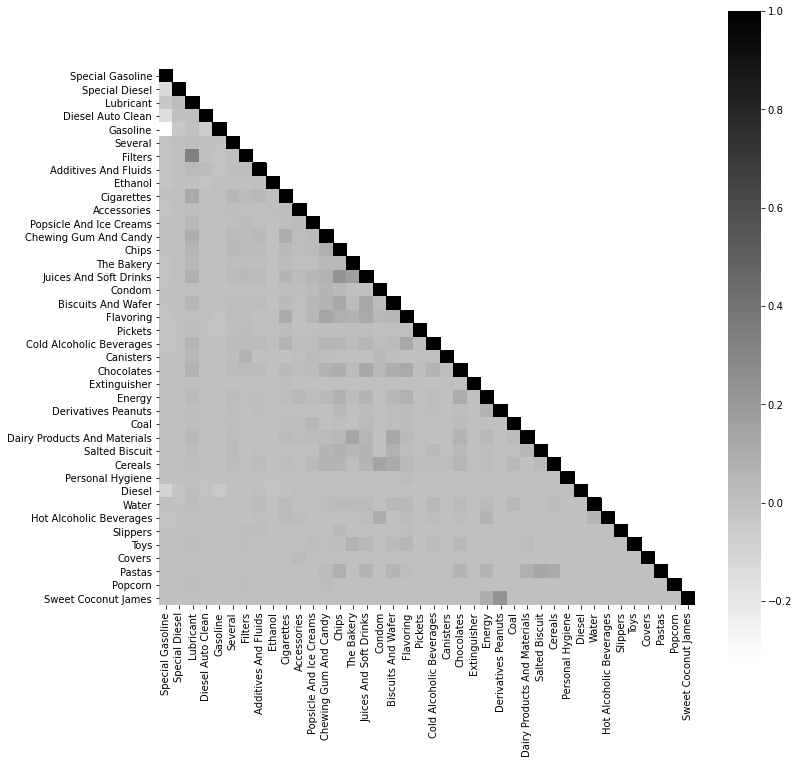

In [233]:
triangle_map(corr)

### Make Graph

In [234]:
# Distance function to transform matrix
distance_function = lambda x: sqrt(2*(1-x))

In [249]:
# Generates a graph object from a binary purchase matrix
def make_graph(vec_df, limit=None):
    # Generate correlation matrix
    corrmat = np.array(vec_df.corr())
    # Limit if required
    corrmat = corrmat[:limit, :limit] if limit else corrmat
    
    return nx.from_numpy_matrix(corrmat)

In [251]:
# Generates an encoded dictionary mapping each 
# node to an encoded value for each product
def make_labels(vec_df, limit=None):
    # Get columns and restrict if specified
    cols = vec_df.columns
    cols = cols[:limit] if limit else cols
    
    # Encode each label
    le = LabelEncoder()
    encoded = le.fit_transform(cols)
    
    # Generate a dict mapping each node to a label
    labels = {i:encoded[i] for i in range(len(cols))}
    
    # Generate a dict mapping each node to a label
#     labels = {}
#     for i in range(len(cols)):
#         labels[i] = encoded[i]
    
    return labels, encoded

In [257]:
# Function to plot a graph (takes in either a pandas dataframe or numpy matrix)
def draw(G, pos=None, labels=None, plotsize=(12,12), limit=None):
    
    # Position nodes using Fruchterman-Reingold force-directed algorithm.
    if pos is None:
        pos = nx.spring_layout(G)
    fig, ax = plt.subplots(figsize=plotsize)
    
    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color='r', node_size=700)
    
    # Draw the edges
    nx.draw_networkx_edges(G, pos, width=2, edge_color='b')
    
    # Draw labels (if specified)
    if labels:
        nx.draw_networkx_labels(G, pos, labels, font_size=20)
        
    plt.show()
    
    
    # Return the list of encoding, so that the graph can be deciphered
    return encoded

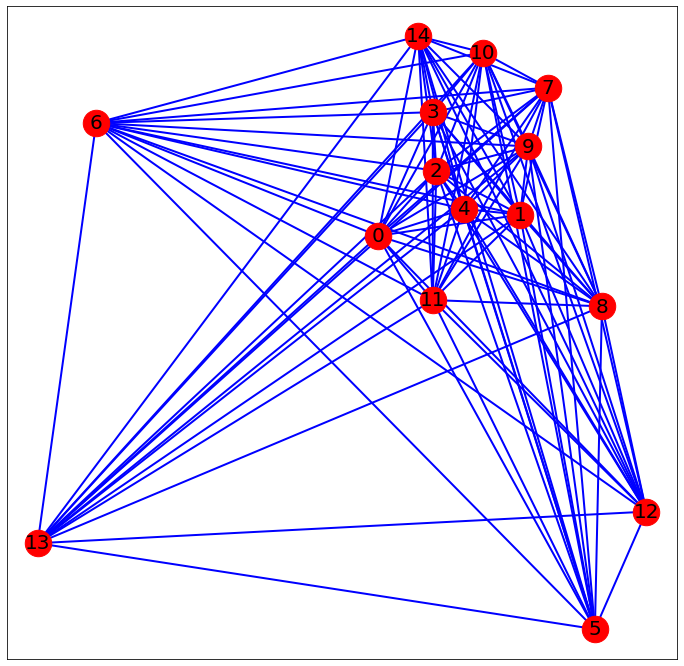

In [267]:
limit = 15
G = make_graph(vectors, limit=limit)
pos = nx.spring_layout(G)
labels, encoded = make_labels(vectors, limit=limit)
draw(G, pos=pos, labels=labels, limit=limit)

code_map = {encoded[i]: vectors.columns[i] for i in range(len(encoded))}

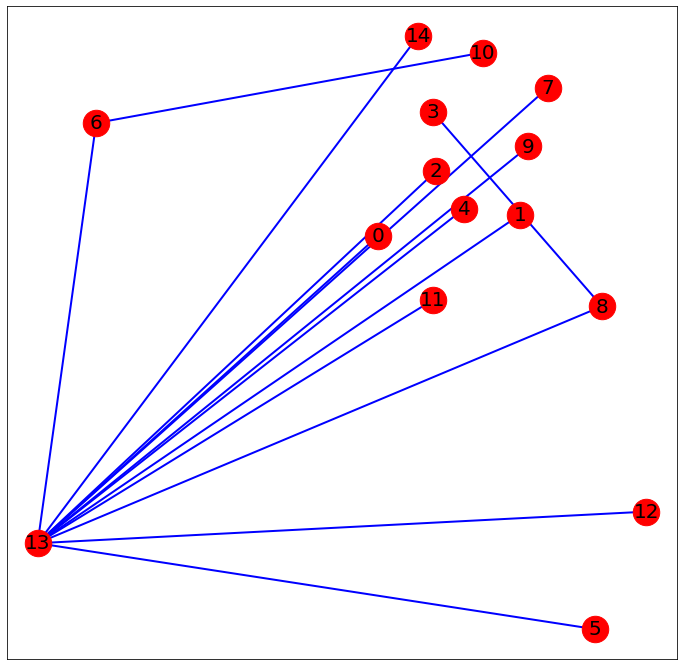

array([13, 12,  9,  5,  8, 11,  7,  1,  6,  4,  0, 10,  2,  3, 14])

In [268]:
draw(nx.minimum_spanning_tree(G), pos=pos, labels=labels)